In [2]:
%matplotlib inline
import scipy.io
import numpy as np
import pandas as pd
from pathlib import Path
import re
from collections import Counter
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset
import torch.utils.data as data
from torchvision import datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [3]:
train_feature_75ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_32wz_75ol.npy')
train_label_75ol = np.load('../Data/UTDMHAD_data/UTD_train_label_32wz_75ol.npy')
test_feature_75ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_32wz_75ol.npy')
test_label_75ol = np.load('../Data/UTDMHAD_data/UTD_test_label_32wz_75ol.npy')

train_feature_50ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_32wz_50ol.npy')
train_label_50ol = np.load('../Data/UTDMHAD_data/UTD_train_label_32wz_50ol.npy')
test_feature_50ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_32wz_50ol.npy')
test_label_50ol = np.load('../Data/UTDMHAD_data/UTD_test_label_32wz_50ol.npy')

train_feature_25ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_32wz_25ol.npy')
train_label_25ol = np.load('../Data/UTDMHAD_data/UTD_train_label_32wz_25ol.npy')
test_feature_25ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_32wz_25ol.npy')
test_label_25ol = np.load('../Data/UTDMHAD_data/UTD_test_label_32wz_25ol.npy')

train_feature_0ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_32wz_0ol.npy')
train_label_0ol = np.load('../Data/UTDMHAD_data/UTD_train_label_32wz_0ol.npy')
test_feature_0ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_32wz_0ol.npy')
test_label_0ol = np.load('../Data/UTDMHAD_data/UTD_test_label_32wz_0ol.npy')

# 32 window_size %75 overlapping

In [4]:
train_dataset_75ol = TensorDataset(torch.from_numpy(train_feature_75ol).to(torch.float32),torch.from_numpy(train_label_75ol).to(torch.float32))

test_dataset_75ol = TensorDataset(torch.from_numpy(test_feature_75ol).to(torch.float32),torch.from_numpy(test_label_75ol).to(torch.float32))


In [5]:
train_loader_75ol = data.DataLoader(dataset = train_dataset_75ol, batch_size = 32, shuffle = True)

test_loader_75ol = data.DataLoader(dataset = test_dataset_75ol, batch_size = 32, shuffle = False)

In [18]:
class CNN_UTD(nn.Module):
    def __init__(self):
        super(CNN_UTD, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(3520, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_75 = CNN_UTD().to(device)

In [19]:
epoches = 20
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_75.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [20]:
## training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_75ol:
        imgs = imgs.reshape(len(imgs),1,32,6)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_75(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  22.68086669114947  % Loss:  2.5917501718225613
Epoch:  2 accuracy:  34.21226588321704  % Loss:  2.096889034403322
Epoch:  3 accuracy:  40.543518178479616  % Loss:  1.8769991397857666
Epoch:  4 accuracy:  45.053250091810504  % Loss:  1.7221473768843172
Epoch:  5 accuracy:  48.703635695923616  % Loss:  1.611051515794136
Epoch:  6 accuracy:  50.811604847594566  % Loss:  1.5192642760388728
Epoch:  7 accuracy:  53.77892030848329  % Loss:  1.4389125813900585
Epoch:  8 accuracy:  55.92361366140286  % Loss:  1.3580042469389562
Epoch:  9 accuracy:  58.222548659566655  % Loss:  1.2938282737429714
Epoch:  10 accuracy:  60.44069041498347  % Loss:  1.214375977365064
Epoch:  11 accuracy:  62.39441792141021  % Loss:  1.1557284765680071
Epoch:  12 accuracy:  64.32611090708777  % Loss:  1.0977607067202177
Epoch:  13 accuracy:  66.24311421226588  % Loss:  1.0556696654065674
Epoch:  14 accuracy:  67.76349614395887  % Loss:  0.9877359427056962
Epoch:  15 accuracy:  69.28387807565186  

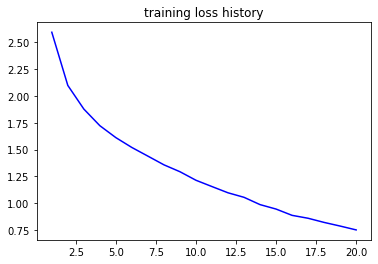

In [22]:
import matplotlib.pyplot as plt
x = []
for i in range(1,21):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [23]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_75ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,6)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_75(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  49.24605894448252


# 32 window_size %50 overlapping

In [24]:
train_dataset_50ol = TensorDataset(torch.from_numpy(train_feature_50ol).to(torch.float32),torch.from_numpy(train_label_50ol).to(torch.float32))

test_dataset_50ol = TensorDataset(torch.from_numpy(test_feature_50ol).to(torch.float32),torch.from_numpy(test_label_50ol).to(torch.float32))

train_loader_50ol = data.DataLoader(dataset = train_dataset_50ol, batch_size = 32, shuffle = True)

test_loader_50ol = data.DataLoader(dataset = test_dataset_50ol, batch_size = 32, shuffle = False)


In [26]:
class CNN_UTD_50(nn.Module):
    def __init__(self):
        super(CNN_UTD_50, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(3520, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_50 = CNN_UTD_50().to(device)
epoches = 20
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_50.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [27]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_50ol:
        imgs = imgs.reshape(len(imgs),1,32,6)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_50(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  18.27262044653349  % Loss:  2.814808272419961
Epoch:  2 accuracy:  29.832549941245592  % Loss:  2.316816548786253
Epoch:  3 accuracy:  35.237955346651  % Loss:  2.0841485972695506
Epoch:  4 accuracy:  39.60047003525264  % Loss:  1.9283271294804247
Epoch:  5 accuracy:  43.06698002350176  % Loss:  1.784101492362403
Epoch:  6 accuracy:  46.46004700352526  % Loss:  1.687443752803713
Epoch:  7 accuracy:  49.26556991774383  % Loss:  1.573340012993611
Epoch:  8 accuracy:  52.291421856639246  % Loss:  1.467766329156401
Epoch:  9 accuracy:  55.15569917743831  % Loss:  1.3802575018484269
Epoch:  10 accuracy:  57.16803760282021  % Loss:  1.3275889317754288
Epoch:  11 accuracy:  60.370152761457106  % Loss:  1.222214077839829
Epoch:  12 accuracy:  62.39717978848414  % Loss:  1.156755029035846
Epoch:  13 accuracy:  64.21856639247943  % Loss:  1.1036214741742667
Epoch:  14 accuracy:  66.42185663924795  % Loss:  1.03053583309684
Epoch:  15 accuracy:  68.66921269095182  % Loss:  0.

In [28]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_50ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,6)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_50(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  41.94653872515421


# 32 window_size %25 overlapping

In [32]:
train_dataset_25ol = TensorDataset(torch.from_numpy(train_feature_25ol).to(torch.float32),torch.from_numpy(train_label_25ol).to(torch.float32))

test_dataset_25ol = TensorDataset(torch.from_numpy(test_feature_25ol).to(torch.float32),torch.from_numpy(test_label_25ol).to(torch.float32))

train_loader_25ol = data.DataLoader(dataset = train_dataset_25ol, batch_size = 32, shuffle = True)

test_loader_25ol = data.DataLoader(dataset = test_dataset_25ol, batch_size = 32, shuffle = False)


In [36]:
class CNN_UTD_25(nn.Module):
    def __init__(self):
        super(CNN_UTD_25, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(3520, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_25 = CNN_UTD_25().to(device)
epoches = 20
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_25.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [37]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_25ol:
        imgs = imgs.reshape(len(imgs),1,32,6)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_25(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  14.125165271044512  % Loss:  2.9484081201150385
Epoch:  2 accuracy:  25.187307183781403  % Loss:  2.5135164848515683
Epoch:  3 accuracy:  31.35742617893345  % Loss:  2.277346685738631
Epoch:  4 accuracy:  36.40370207139709  % Loss:  2.0860377902715976
Epoch:  5 accuracy:  39.40061701189951  % Loss:  1.9565894293113493
Epoch:  6 accuracy:  41.780520052886736  % Loss:  1.8349828929968284
Epoch:  7 accuracy:  45.813133539003964  % Loss:  1.7082097983696092
Epoch:  8 accuracy:  48.72190392243279  % Loss:  1.6211552485613756
Epoch:  9 accuracy:  51.36624063464081  % Loss:  1.5055127362130394
Epoch:  10 accuracy:  54.58351696782724  % Loss:  1.4271448724706408
Epoch:  11 accuracy:  57.88893785808726  % Loss:  1.3269594991710825
Epoch:  12 accuracy:  60.709563684442486  % Loss:  1.232490964758564
Epoch:  13 accuracy:  62.9352137505509  % Loss:  1.1614797241251233
Epoch:  14 accuracy:  65.35918907007492  % Loss:  1.0855275707345613
Epoch:  15 accuracy:  67.87130894667254  

In [38]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_25ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,6)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_25(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  41.67523124357657


# 32 window_size %0 overlapping

In [39]:
train_dataset_0ol = TensorDataset(torch.from_numpy(train_feature_0ol).to(torch.float32),torch.from_numpy(train_label_0ol).to(torch.float32))

test_dataset_0ol = TensorDataset(torch.from_numpy(test_feature_0ol).to(torch.float32),torch.from_numpy(test_label_0ol).to(torch.float32))

train_loader_0ol = data.DataLoader(dataset = train_dataset_0ol, batch_size = 32, shuffle = True)

test_loader_0ol = data.DataLoader(dataset = test_dataset_0ol, batch_size = 32, shuffle = False)


In [40]:
class CNN_UTD_0(nn.Module):
    def __init__(self):
        super(CNN_UTD_0, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(3520, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_0 = CNN_UTD_0().to(device)
epoches = 20
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_0.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [41]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_0ol:
        imgs = imgs.reshape(len(imgs),1,32,6)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_0(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  12.72032902467685  % Loss:  3.0119180211396976
Epoch:  2 accuracy:  23.707403055229143  % Loss:  2.591802924592918
Epoch:  3 accuracy:  28.936545240893068  % Loss:  2.356608413090216
Epoch:  4 accuracy:  33.07873090481786  % Loss:  2.1977288767556162
Epoch:  5 accuracy:  36.28084606345476  % Loss:  2.060564413248936
Epoch:  6 accuracy:  40.4524089306698  % Loss:  1.9142756239276066
Epoch:  7 accuracy:  42.53819036427732  % Loss:  1.8108625723936846
Epoch:  8 accuracy:  45.50528789659224  % Loss:  1.7202065358652132
Epoch:  9 accuracy:  48.413631022326676  % Loss:  1.6279930121430726
Epoch:  10 accuracy:  51.93889541715629  % Loss:  1.5045146351662753
Epoch:  11 accuracy:  55.25851938895417  % Loss:  1.4044241816083962
Epoch:  12 accuracy:  56.786133960047  % Loss:  1.3264305335338984
Epoch:  13 accuracy:  60.54641598119859  % Loss:  1.2323707119326726
Epoch:  14 accuracy:  62.54406580493537  % Loss:  1.159917518914303
Epoch:  15 accuracy:  65.951821386604  % Loss: 

In [42]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_0ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,6)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_0(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  38.24537354352296
